**Update 1**: A more complete and updated speed comparison can be found [here](http://rlhick.people.wm.edu/posts/comparing-the-speed-of-matlab-versus-pythonnumpy-partii.html).

**Update 2**: Python and Matlab code edited on 4/5/2015.

In this short note, we compare the speed of matlab and the scientific computing platform of python for a simple bootstrap of an ordinary least squares model.  Bottom line (with caveats): matlab is faster than python with this code.  One might be able to further optimize the python code below, but it isn't an obvious or easy process (see for example [advanced optimization techniques](http://scipy-lectures.github.io/advanced/optimizing/)).

As an aside, this note demonstrates that even if one can't optimize python code significantly enough, it is possible to do computationally expensive calculations in matlab and return results to the ipython notebook. 

## Data Setup

We will bootstrap the ordinary least squares model (ols) using 1000 replicates.  For generating the toy dataset, the true parameter values are
$$
\beta=\begin{bmatrix}
10\\-.5\\.5
\end{bmatrix}
$$

We perform the experiment for 3 different sample sizes (\\(n = \begin{bmatrix}1,000 & 10,000 & 100,000 \end{bmatrix}\\)). For each of the observations in the toy dataset, the independent variables are drawn from

$$
\mu_x = \begin{bmatrix} 10\\10 \end{bmatrix}, \sigma_x = \begin{bmatrix} 4 & 0 \\ 0 & 4 \end{bmatrix}
$$

The dependent variable is constructed by drawing a vector of random normal variates from Normal(0,1).  Denoting this vector as \\(\epsilon\\) calculate the dependent variable as
$$
\mathbf{Y=Xb+\epsilon}
$$
<!--TEASER_END-->

## What is timed

In the code below, the data generation steps described above are not timed.  For comparison purposes, we only include the steps required for the bootstrap process.  This includes:

1. Sampling rows of data with replacement
2. Calculating parameter estimates for the OLS model
3. Storing results

For these steps, we have done some basic code optimization in both python and matlab by preallocating arrays/matrices.

It is also important to note that we use built-in functions for calculating parameter estimates (`ols` for matlab and `statsmodels.regression.linear_model.OLS` for python).  If these functions aren't optimized for speed, then these results will obviously be skewed towards that package having the more optimized linear regression model function.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import statsmodels.api as sm
from timeit import timeit
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge
Send 'exit' command to kill the server
.MATLAB started and connected!


In [2]:
reps, beta, n_array = 1000, [10,-.5,.5], [1000, 10000, 100000]

# Run the bootstrap in Matlab

In [3]:
%%matlab -i reps,beta,n_array -o mat_time,store_beta

mat_time = zeros(cols(n_array),2);
    
for i=1:3
n=n_array(i);
row_id =1:n;

X = [normrnd(10,4,[n 2]) ones(n,1)];    
    
Y = X*beta' + normrnd(0,1,[n 1]);

    store_beta = zeros(reps,3); 
    tic
    for r = 1:reps
       this_row = randsample(row_id,n,true);
       store_beta(r,:) = (ols(Y(this_row),X(this_row,:)))'; 
    end
    mat_time(i,:) = [n toc];
end

In [4]:
matlab_results = pd.DataFrame(store_beta.copy(),columns=['b0','b1','b2'])
print "Here are the Matlab results for n = 100,000"
matlab_results.describe()

Here are the Matlab results for n = 100,000


b0           b1           b2
count  1000.000000  1000.000000  1000.000000
mean      9.999913    -0.501554     0.518378
std       0.000820     0.000785     0.011911
min       9.996906    -0.503905     0.486200
25%       9.999368    -0.502104     0.510149
50%       9.999908    -0.501557     0.518545
75%      10.000502    -0.501017     0.526612
max      10.002367    -0.499192     0.554077

# Run the bootstrap in python

In [5]:
def python_boot():
    for r in np.arange(reps):
        this_sample = np.random.choice(row_id, size=n, replace=True) # gives sampled row numbers
        # Define data for this replicate:    
        X_r = X[this_sample,:]
        Y_r = Y[this_sample]
        # Estimate model 
        store_beta[r,:] = sm.regression.linear_model.OLS(Y_r,X_r).fit(disp=0).params   

In [6]:
python_time = np.zeros((len(n_array),2))
count=0

for n in n_array:
    # Constructs toy data
    row_id = range(0,n)
    X1 = np.random.normal(10,4,(n,1))
    X2 = np.random.normal(10,4,(n,1))
    X=np.append(X1,X2,1)
    X = np.append(X,np.tile(1,(n,1)),1)
    error = np.random.randn(n,1)
    Y = np.dot(X,beta).reshape((n,1)) + error
    
    store_beta = np.zeros((reps,X.shape[1]))
    TimeIt = timeit("python_boot()", setup="from __main__ import python_boot", number=1)
    python_time[count,:] = [n,TimeIt]
    count=count+1

In [7]:
results = pd.DataFrame(store_beta,columns=['b0','b1','b2'])
print "Here are the results for n = 100,000"
results.describe()

Here are the results for n = 100,000


b0           b1           b2
count  1000.000000  1000.000000  1000.000000
mean     10.001015    -0.501155     0.501976
std       0.000806     0.000773     0.011775
min       9.998609    -0.503459     0.461239
25%      10.000454    -0.501663     0.494047
50%      10.000983    -0.501155     0.502325
75%      10.001581    -0.500628     0.509737
max      10.004093    -0.498803     0.546887

# Discussion

Having run the bootstrap for \\(n = \begin{bmatrix}1,000 & 10,000 & 100,000 \end{bmatrix}\\), we see that 

1. Matlab outperforms python for any sample size.
2. As the sample size increases, the gap between python and matlab increases

This can be seen in the figure below.

While running numerical analysis in python does take a performance hit, this short example shows the flexibility of the Ipython Notebook.  You can run code in matlab, transfer data in and out and retain all of the advantages of both numerical computing platforms.


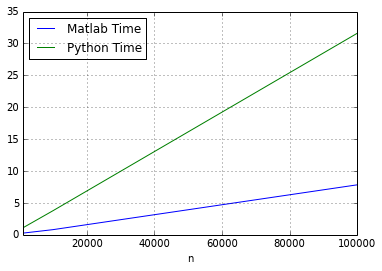

In [8]:
# Convert to pandas dataframe for plotting:
matlab_data=pd.DataFrame(mat_time,columns=['n','Matlab Time'])
python_data=pd.DataFrame(python_time,columns=['n','Python Time'])
plot_data = pd.concat([matlab_data,python_data['Python Time']], axis=1)
plot_data = plot_data.set_index('n')
plot_data.plot()

In [9]:
plot_data.head()

Matlab Time  Python Time
n                               
1000       0.257269     1.064270
10000      0.808506     3.776620
100000     7.839279    31.610367